In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
import time
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

import tensorflow as tf
# tf.enable_eager_execution()

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, confusion_matrix

from imageloader import imagefolder

In [2]:
tf.Variable(True)

Instructions for updating:
Colocations handled automatically by placer.


<tf.Variable 'Variable:0' shape=() dtype=bool_ref>

## Flowers

https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz

In [3]:
basedir = '/home/q1park/visions/data/'
subclasses = ['1', '10', '20']

imgloader = imagefolder(basedir, [120, 120], 3)
imgloader.loadpaths('train', classes = subclasses)
imgloader.loadpaths('test', classes = subclasses)
imgloader.npload(norm = True, onehot = True, ncores = 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


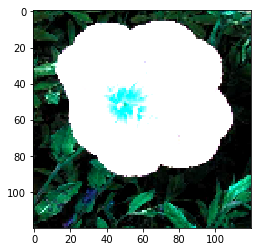

In [4]:
def plot_image(image):
    fig, ax = plt.subplots(1, 1)
    
    if image.shape[2] == 1:
        image = image[:, :, 0]
    ax.imshow(image.astype(int), cmap = 'gray')
    plt.show()

npimg = imgloader.npdict['test'][0][0, :, :, :]
plot_image(200.*(npimg + 1.) )

## API-free Network Design

In [5]:
class Network:
    def __init__(self, inputshape, nchannels, nclasses):
        self.nchannels = nchannels
        self.nclasses = nclasses
        self.layers, self.shapes = {}, {}
        self.weights, self.biases = {}, {}
        self.finalresults = {}
        
        self.ilayer = 0
        inputsize = np.prod(inputshape + [nchannels])
        
        self.droprate = tf.placeholder(tf.float32)
        self.x = tf.placeholder(tf.float32, shape=[None, inputsize], name='x')
        self.y = tf.placeholder(tf.float32, shape=[None, self.nclasses], name='y')
        self.yclass = tf.argmax(self.y, axis=1)
        
        self.weights['0_Init'] = None
        self.biases['0_Init'] = None
        self.shapes['0_Init'] = inputshape + [nchannels]
        self.layers['0_Init'] = self.x
        
    def _initweights(self, shape):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.05, dtype=tf.float32))

    def _initbias(self, length):
        return tf.Variable(tf.constant(0.05, shape=[length]))
    
    def initconv2d(self):
        batchshape = [-1] + self.shapes['0_Init'][:-1] + [self.nchannels]
        self.layers['0_Init'] = tf.reshape(self.layers['0_Init'], batchshape)
        
    def activate(self, activation = 'relu'):
        prename = list(self.layers.keys())[-1]
        assert activation in ['relu', 'sigmoid']
        
        if activation is 'relu':
            self.layers[prename] = tf.nn.relu(self.layers[prename])
        elif activation is 'sigmoid':
            self.layers[prename] = tf.nn.sigmoid(self.layers[prename])
        
    def dropout(self):
        prename = list(self.layers.keys())[-1]
        assert len(self.shapes[prename]) == 1
        
        self.layers[prename] = tf.nn.dropout(self.layers[prename], rate = self.droprate)

    def pool(self, poolsize):
        prename = list(self.layers.keys())[-1]
        assert len(self.shapes[prename]) == 3
        assert len(poolsize) == 2
        
        self.ilayer += 1
        name = str(self.ilayer) + '_Pool'
        
        ksize = [1] + poolsize + [1]
        strides = [1] + poolsize + [1]
        self.layers[name] = tf.nn.max_pool(self.layers[prename], ksize=ksize, \
                                           strides=strides, padding='SAME')
        self.weights[name] = None
        self.biases[name] = None
        self.shapes[name] = self.layers[name].get_shape()[1:].as_list()
        
    def flatten(self):
        prename = list(self.layers.keys())[-1]
        assert len(self.shapes[prename]) == 3
        
        self.ilayer += 1
        name = str(self.ilayer) + '_Flat'
        self.shapes[name] = [np.prod(self.layers[prename].get_shape()[1:].as_list())]
        self.layers[name] = tf.reshape(self.layers[prename], [-1, self.shapes[name][0]])
        self.weights[name] = None
        self.biases[name] = None
        
    def addconv2d(self, inchannels, outchannels, kernel, stride):
        prename = list(self.layers.keys())[-1]
        self.ilayer += 1
        name = str(self.ilayer) + '_Conv2D'
        
        shape = [kernel, kernel, inchannels, outchannels]
        weights = self._initweights(shape = shape)
        biases = self._initbias(length = outchannels)
        strides = [1] + [stride, stride] + [1]

        self.layers[name] = tf.nn.conv2d(self.layers[prename], weights, \
                                         strides=strides, padding='SAME') + biases  
        self.shapes[name] = self.layers[name].get_shape()[1:].as_list()
        self.weights[name] = weights
        self.biases[name] = biases
    
    def addlinear(self, outputsize):
        prename = list(self.layers.keys())[-1]
        assert len(self.shapes[prename]) == 1
        
        self.ilayer += 1
        name = str(self.ilayer) + '_Linear'
        
        shape = [np.prod(self.shapes[prename]), outputsize]
        weights = self._initweights(shape=shape)
        biases = self._initbias(length=outputsize)
        
        self.layers[name] = tf.matmul(self.layers[prename], weights) + biases
        self.shapes[name] = self.layers[name].get_shape()[1:].as_list()
        self.weights[name] = weights
        self.biases[name] = biases
        
    def addfinal(self):
        prename = list(self.layers.keys())[-1]
        
        self.ilayer += 1
        name = 'Final'
        
        shape = [np.prod(self.shapes[prename]), self.nclasses]
        weights = self._initweights(shape=shape)
        biases = self._initbias(length=self.nclasses)
        
        self.layers[name] = tf.add(tf.matmul(self.layers[prename], weights), \
                                   biases, name='final')
        self.shapes[name] = self.layers[name].get_shape()[1:].as_list()
        self.weights[name] = weights
        self.biases[name] = biases
        
    def confusionmatrix(self):
        assert len(self.finalresults) == 2
        
        cm = confusion_matrix(self.finalresults['truth'], self.finalresults['predictions'])
        plt.matshow(cm)
        plt.colorbar()
        tick_marks = np.arange(self.nclasses)
        plt.xticks(tick_marks, range(self.nclasses))
        plt.yticks(tick_marks, range(self.nclasses))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
    def train(self, dataloader, batchsize, learnrate, nepochs, printevery = 10):
        prename = list(self.layers.keys())[-1]
        pretag = self.layers[prename].name.split('_')[0]
        assert prename is 'Final'
        assert pretag not in ['Relu']
        
        ypred = tf.nn.softmax(self.layers[prename])
        ypredclass = tf.argmax(ypred, axis=1)

        correct = tf.equal(self.yclass, ypredclass)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
        xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.layers[prename], \
                                                              labels=self.y)
        loss = tf.reduce_mean(xentropy)
        optimizer = tf.train.AdamOptimizer(learning_rate=learnrate).minimize(loss)
        
        global epoch
        epoch = 0
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            start_time = time.time()
            
            trainloss, trainacc, nbatches = 0, 0, 0

            for e in range(epoch, epoch + nepochs):
                batchid = dataloader.npbatchid(xtype = 'train', batchsize = batchsize)
                traindata = dataloader.npdict['train']
                
                for i, ibatch in enumerate(batchid):
                    x_train = traindata[0][ibatch]
                    y_train = traindata[1][ibatch]

                    x_train = x_train.reshape(-1, np.prod(self.shapes['0_Init']))
                    feed_dict_train = {self.x: x_train, self.y: y_train, \
                                       self.droprate: 0.4}
                    _, batchloss, batchacc = sess.run([optimizer, loss, accuracy], \
                                                      feed_dict=feed_dict_train)
                    trainloss += batchloss
                    trainacc += batchacc
                    nbatches += 1

                if e%printevery == 0:
                    # Calculate training averages
                    avgloss = trainloss/nbatches
                    avgacc = trainacc/nbatches
                    trainloss, trainacc, nbatches = 0, 0, 0

                    # Calculate test accuracy
                    x_test, y_test = dataloader.npdict['test']
                    x_test = x_test.reshape(-1, np.prod(self.shapes['0_Init']))
                    feed_dict_test = {self.x: x_test, self.y: y_test, self.droprate: 0.0}

                    testacc, testloss = sess.run([accuracy, loss], feed_dict=feed_dict_test)

                    msg = "Epoch: {0:>1}, Train Loss: {1:.2f}, Train Acc: {2:>6.1%} {3:>3}"
                    testmsg = "Test Loss: {0:.2f}, Test Acc: {1:>6.1%}"
                    print(msg.format(e + 1, avgloss, avgacc, '') + testmsg.format(testloss, testacc))

            epoch += nepochs

            end_time = time.time()
            time_dif = end_time - start_time
            
            print("\n###### Training complete ######")
            print("###### Time usage: " + str(timedelta(seconds=int(round(time_dif)))) + "\n")
            
            x_test, y_test = dataloader.npdict['test']
            x_test = x_test.reshape(-1, np.prod(self.shapes['0_Init']))
            feed_dict_test = {self.x: x_test, self.y: y_test, self.droprate: 0.0}
                    
            final_acc, final_ypred = sess.run([accuracy, ypredclass], feed_dict=feed_dict_test)
            final_ytrue = np.argmax(y_test, 1)
            
            self.finalresults['truth'] = final_ytrue
            self.finalresults['predictions'] = final_ypred
            
            print("Accuracy:", np.around(final_acc, 3) )
#             print("Precision:", np.around(precision_score(final_ytrue, final_ypred, average='micro'), 3) )
#             print("Recall:", np.around(recall_score(final_ytrue, final_ypred, average='micro'), 3) )
#             print("F1:", np.around(f1_score(final_ytrue, final_ypred, average='micro'), 3) )

In [6]:
testnet = Network(imgloader.imgshape, imgloader.nchannels, len(imgloader.classdict))
testnet.initconv2d()

testnet.addconv2d(3, 16, 4, 1)
testnet.activate(activation = 'relu')
testnet.pool(poolsize = [2, 2])

testnet.addconv2d(16, 32, 4, 1)
testnet.activate(activation = 'relu')
testnet.pool(poolsize = [2, 2])

testnet.addconv2d(32, 64, 4, 1)
testnet.activate(activation = 'relu')
testnet.pool(poolsize = [2, 2])

testnet.flatten()
testnet.addlinear(50)
testnet.activate(activation = 'relu')
testnet.dropout()
testnet.addlinear(50)
testnet.activate(activation = 'relu')
testnet.dropout()
testnet.addfinal()

testnet.layers

{'0_Init': <tf.Tensor 'Reshape:0' shape=(?, 120, 120, 3) dtype=float32>,
 '1_Conv2D': <tf.Tensor 'Relu:0' shape=(?, 120, 120, 16) dtype=float32>,
 '2_Pool': <tf.Tensor 'MaxPool:0' shape=(?, 60, 60, 16) dtype=float32>,
 '3_Conv2D': <tf.Tensor 'Relu_1:0' shape=(?, 60, 60, 32) dtype=float32>,
 '4_Pool': <tf.Tensor 'MaxPool_1:0' shape=(?, 30, 30, 32) dtype=float32>,
 '5_Conv2D': <tf.Tensor 'Relu_2:0' shape=(?, 30, 30, 64) dtype=float32>,
 '6_Pool': <tf.Tensor 'MaxPool_2:0' shape=(?, 15, 15, 64) dtype=float32>,
 '7_Flat': <tf.Tensor 'Reshape_1:0' shape=(?, 14400) dtype=float32>,
 '8_Linear': <tf.Tensor 'dropout/mul:0' shape=(?, 50) dtype=float32>,
 '9_Linear': <tf.Tensor 'dropout_1/mul:0' shape=(?, 50) dtype=float32>,
 'Final': <tf.Tensor 'final:0' shape=(?, 3) dtype=float32>}

In [7]:
testnet.train(imgloader, batchsize = 25, learnrate = 0.0001, nepochs=30, printevery = 5)

Epoch: 1, Train Loss: 1.10, Train Acc:  33.0%    Test Loss: 1.10, Test Acc:  27.3%
Epoch: 6, Train Loss: 1.07, Train Acc:  41.6%    Test Loss: 1.12, Test Acc:  36.4%
Epoch: 11, Train Loss: 1.02, Train Acc:  50.6%    Test Loss: 1.05, Test Acc:  54.5%
Epoch: 16, Train Loss: 0.93, Train Acc:  59.4%    Test Loss: 0.90, Test Acc:  45.5%
Epoch: 21, Train Loss: 0.77, Train Acc:  69.2%    Test Loss: 0.69, Test Acc:  54.5%
Epoch: 26, Train Loss: 0.64, Train Acc:  73.0%    Test Loss: 0.58, Test Acc:  63.6%

###### Training complete ######
###### Time usage: 0:01:06

Accuracy: 0.636


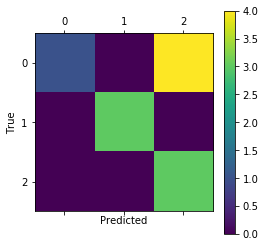

In [8]:
testnet.confusionmatrix()